In [121]:
# bibliotecas matetmáticas
import math
import pandas as pd
import numpy as np

# bibliotecas para uso de redes neurais. Neste caso, do tipo LSTM
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

# bibliotecas para o pré-processamento dos dados. Normalização, etc...
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_squared_error
from scipy.signal import savgol_filter
import datetime
from functools import reduce

# bibliotecas para representação dos dados em gráficos
import plotly.offline as py
import plotly.graph_objs as go
import matplotlib.pyplot as plt

Leitura do dataset referente ao período de 8:05 até 8:20 da manhã do NGSIM us-101. São lidas as 100 mil primeiras linhas.

In [72]:
#Leitura dos 100 mil primeiros registros do conjunto de dados

#df = pd.read_csv('NGSIM.csv', nrows=100000)
#df = pd.read_csv('us-101-vehicle-trajectory-data/vehicle-trajectory-data/0750am-0805am/trajectories-0750am-0805am.csv', nrows=100000)
df = pd.read_csv('us-101-vehicle-trajectory-data/vehicle-trajectory-data/0805am-0820am/trajectories-0805am-0820am.csv', nrows=100000)

In [77]:
df.head(1000)

,Vehicle_ID,Frame_ID,Total_Frames,Global_Time,Local_X,Local_Y,Global_X,Global_Y,v_Length,v_Width,v_Class,v_Vel,v_Acc,Lane_ID,Preceeding,Following,Space_Hdwy,Time_Hdwy
0,1,270,569,1118847869000,51.164,112.878,6451136.708,1873294.084,47.0,8.5,3,19.89,0.00,5,0,0,0.00,0.00
1,1,271,569,1118847869100,51.153,114.878,6451138.053,1873292.603,47.0,8.5,3,19.89,0.00,5,0,0,0.00,0.00
2,1,272,569,1118847869200,51.143,116.878,6451139.397,1873291.122,47.0,8.5,3,19.89,0.00,5,0,0,0.00,0.00
3,1,273,569,1118847869300,51.244,118.815,6451140.617,1873289.614,47.0,8.5,3,19.89,0.00,5,0,0,0.00,0.00
4,1,274,569,1118847869400,51.234,120.814,6451141.961,1873288.133,47.0,8.5,3,19.89,1.07,5,0,0,0.00,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,16,346,552,1118847876600,51.575,79.684,6451114.218,1873318.501,15.5,6.4,2,20.67,0.00,5,6,0,101.41,4.91
9996,16,347,552,1118847876700,51.580,81.751,6451115.595,1873316.960,15.5,6.4,2,20.67,0.00,5,6,0,101.66,4.92
9997,16,348,552,1118847876800,51.586,83.818,6451116.972,1873315.419,15.5,6.4,2,20.67,0.00,5,6,0,101.98,4.93
9998,16,349,552,1118847876900,51.592,85.884,6451118.349,1873313.877,15.5,6.4,2,20.67,0.00,5,6,0,102.32,4.95


In [78]:
df.tail()

,Vehicle_ID,Frame_ID,Total_Frames,Global_Time,Local_X,Local_Y,Global_X,Global_Y,v_Length,v_Width,v_Class,v_Vel,v_Acc,Lane_ID,Preceeding,Following,Space_Hdwy,Time_Hdwy
99995,180,1201,528,1118847962100,30.579,524.995,6451446.851,1873016.129,15.0,6.9,2,41.03,-3.95,3,177,184,54.44,1.33
99996,180,1202,528,1118847962200,30.517,529.096,6451449.928,1873013.377,15.0,6.9,2,40.46,-7.39,3,177,184,54.33,1.34
99997,180,1203,528,1118847962300,30.455,533.083,6451453.005,1873010.625,15.0,6.9,2,40.08,-3.25,3,177,184,54.33,1.36
99998,180,1204,528,1118847962400,30.448,537.036,6451456.081,1873007.874,15.0,6.9,2,40.08,3.52,3,177,184,54.39,1.36
99999,180,1205,528,1118847962500,30.448,541.042,6451459.158,1873005.122,15.0,6.9,2,40.34,5.16,3,177,184,54.45,1.35


In [4]:
len(df)

100000

Todas as colunas do NGSIM us-101:

In [7]:
df.columns

Index(['Vehicle_ID', 'Frame_ID', 'Total_Frames', 'Global_Time', 'Local_X',
       'Local_Y', 'Global_X', 'Global_Y', 'v_Length', 'v_Width', 'v_Class',
       'v_Vel', 'v_Acc', 'Lane_ID', 'Preceeding', 'Following', 'Space_Hdwy',
       'Time_Hdwy'],
      dtype='object')

Métodos __get_vehicle_dataset()__ para gerar um _DataFrame_ com todas as linhas de um veículo específico e __get_surround_dataset_from_same_frames_of_target()__ para gerar um dataset de acordo com os _frames_ em que aparece com o veículo alvo.

Os parâmentros para _get_vehicle_dataset()_ são:
* __full_df__: dataset que contém todas os dados completos
* __vehicle_id__: ID do veículo principal que o _DataFrame_ gerado se refere
* __position__: qual o campo que o _vehicle_id_ será comparado durante a busca. Pode ser _Vehicle_ID_, _Preceeding_ ou _Following_.

Os parâmentros para _get_surround_dataset_from_same_frames_of_target()_ são:
* __target_df__: dataset com as informações do veículo alvo para comparar os frames desejados
* __surround_df__: dataset dos veículos em algumas das posições ao redor selecionadas

In [123]:
# Criação de Dataset com informações do veículo de interesse

def get_vehicle_dataset(full_df, vehicle_id, position="Vehicle_ID"):
    target_df = pd.DataFrame(columns=['Vehicle_ID',
                                      'Frame_ID', 
                                      'Global_Time', 
                                      'Local_X',
                                      'Local_Y',
                                      'v_Vel',
                                      'v_Class',
                                      'Preceeding',
                                      'Following'])

    for index, row in full_df.iterrows():
        if row[position] == vehicle_id:
            target_df = target_df.append({'Vehicle_ID': row['Vehicle_ID'],
                                          'Frame_ID': row['Frame_ID'],
                                          'Global_Time': row['Global_Time'],
                                          'Local_X': row['Local_X'],
                                          'Local_Y': row['Local_Y'],
                                          'v_Vel': row['v_Vel'],
                                          'v_Class': row['v_Class'],
                                          'Preceeding': row['Preceeding'],
                                          'Following': row['Following']}, ignore_index=True)

    target_df = target_df.astype({'Vehicle_ID': 'int',
                                  'Frame_ID': 'int',
                                  'Global_Time': 'int',
                                  'v_Class': 'int',
                                  'Preceeding': 'int',
                                  'Following': 'int'})

    return target_df

# Criação de dataset com informações dos veículos ao redor

def get_surround_dataset_from_same_frames_of_target(target_df, surround_df):
    final_df = pd.DataFrame(columns=['Vehicle_ID',
                                      'Frame_ID', 
                                      'Global_Time', 
                                      'Local_X',
                                      'Local_Y',
                                      'v_Vel',
                                      'v_Class',
                                      'Preceeding',
                                      'Following'])

    for index, row in surround_df.iterrows():
        for i, line in target_df.iterrows():
            if row['Frame_ID'] == line['Frame_ID']:
                final_df = final_df.append({'Vehicle_ID': row['Vehicle_ID'],
                                              'Frame_ID': row['Frame_ID'],
                                              'Global_Time': row['Global_Time'],
                                              'Local_X': row['Local_X'],
                                              'Local_Y': row['Local_Y'],
                                              'v_Vel': row['v_Vel'],
                                              'v_Class': row['v_Class'],
                                              'Preceeding': row['Preceeding'],
                                              'Following': row['Following']}, ignore_index=True)
                break

    final_df = final_df.astype({'Vehicle_ID': 'int',
                                  'Frame_ID': 'int',
                                  'Global_Time': 'int',
                                  'v_Class': 'int',
                                  'Preceeding': 'int',
                                  'Following': 'int'})

    return final_df

In [124]:
full_target_df = get_vehicle_dataset(df, 16)

Gerando um _DataFrame_ do veículo alvo. São utilizados os últimos 100 frames em que o veículo aparece, o que equivalem à 10 segundos.

In [125]:
target_df = full_target_df[-100:]
target_df.head()

,Vehicle_ID,Frame_ID,Global_Time,Local_X,Local_Y,v_Vel,v_Class,Preceeding,Following
452,16,778,1118847919800,52.973,1613.870,54.28,2,1,21
453,16,779,1118847919900,52.960,1619.293,53.47,2,1,21
454,16,780,1118847920000,52.943,1624.595,52.40,2,1,21
455,16,781,1118847920100,52.900,1629.770,51.34,2,1,21
456,16,782,1118847920200,52.855,1634.832,50.55,2,1,21


In [126]:
target_df.tail()

,Vehicle_ID,Frame_ID,Global_Time,Local_X,Local_Y,v_Vel,v_Class,Preceeding,Following
547,16,873,1118847929300,56.091,2139.412,59.94,2,0,21
548,16,874,1118847929400,56.124,2145.403,59.94,2,0,21
549,16,875,1118847929500,56.197,2151.395,59.94,2,0,21
550,16,876,1118847929600,56.192,2157.395,59.94,2,0,21
551,16,877,1118847929700,56.188,2163.395,59.94,2,0,21


Gerando um _DataFrame_ do veículo atrás do veículo alvo.

In [127]:
behind_df = get_vehicle_dataset(df, 16, "Preceeding")
behind_df = get_surround_dataset_from_same_frames_of_target(target_df, behind_df)
behind_df.head()

,Vehicle_ID,Frame_ID,Global_Time,Local_X,Local_Y,v_Vel,v_Class,Preceeding,Following
0,21,778,1118847919800,55.663,1479.81,50.0,2,16,25
1,21,779,1118847919900,55.653,1484.81,50.0,2,16,25
2,21,780,1118847920000,55.643,1489.81,50.0,2,16,25
3,21,781,1118847920100,55.634,1494.81,50.0,2,16,25
4,21,782,1118847920200,55.623,1499.81,50.0,2,16,25


In [128]:
behind_df.tail()

,Vehicle_ID,Frame_ID,Global_Time,Local_X,Local_Y,v_Vel,v_Class,Preceeding,Following
95,21,873,1118847929300,54.965,1971.695,56.64,2,16,25
96,21,874,1118847929400,55.010,1977.429,57.12,2,16,25
97,21,875,1118847929500,55.132,1983.206,57.02,2,16,25
98,21,876,1118847929600,55.155,1988.908,56.44,2,16,25
99,21,877,1118847929700,55.105,1994.480,55.99,2,16,25


Gerando um _DataFrame_ do veículo à frente do veículo alvo.

In [129]:
front_df = get_vehicle_dataset(df, 16, "Following")
front_df = get_dataset_from_same_frames_of_target(target_df, front_df)
front_df.head()

,Vehicle_ID,Frame_ID,Global_Time,Local_X,Local_Y,v_Vel,v_Class,Preceeding,Following
0,1,778,1118847919800,55.835,1812.519,56.04,3,0,16
1,1,779,1118847919900,55.985,1818.115,56.30,3,0,16
2,1,780,1118847920000,56.088,1823.736,56.91,3,0,16
3,1,781,1118847920100,56.166,1829.467,57.67,3,0,16
4,1,782,1118847920200,56.201,1835.319,57.96,3,0,16


In [130]:
front_df.tail()

,Vehicle_ID,Frame_ID,Global_Time,Local_X,Local_Y,v_Vel,v_Class,Preceeding,Following
56,1,834,1118847925400,56.965,2143.216,59.06,3,0,16
57,1,835,1118847925500,56.946,2149.061,58.76,3,0,16
58,1,836,1118847925600,56.942,2154.789,58.76,3,0,16
59,1,837,1118847925700,56.937,2160.789,58.76,3,0,16
60,1,838,1118847925800,56.932,2166.789,58.76,3,0,16


Gerando um _DataFrame_ do veículo à frente do veículo à frente do alvo.

In [131]:
front_front_df = get_vehicle_dataset(df, 1, "Following")
front_front_df = get_dataset_from_same_frames_of_target(front_df, front_front_df)
front_front_df.head()

,Vehicle_ID,Frame_ID,Global_Time,Local_X,Local_Y,v_Vel,v_Class,Preceeding,Following


Métodos __get_left_or_right_vehicle_dataset()__ para gerar um _DataFrame_ com todas as linhas dos veículos à esquerda ou à direita do veículo alvo.

Os parâmentros para _get_left_or_right_vehicle_dataset()_ são:
* __full_df__: _DataFrame_ que contém todas os dados completos
* __target_df__: _DataFrame_ que contém as informações do veículo alvo
* __side__: qual o lado que os veículos buscados estará em relação ao alvo. Pode ser _Left_ ou _Right_.

In [133]:
# Criação de Dataset com informações dos veículos à esquerda ou à direita do veículo alvo

def get_left_or_right_vehicle_dataset(full_df, target_df, side="left"):
    side_df = pd.DataFrame(columns=['Vehicle_ID',
                                      'Frame_ID', 
                                      'Global_Time', 
                                      'Local_X',
                                      'Local_Y',
                                      'v_Vel',
                                      'v_Class',
                                      'Preceeding',
                                      'Following'])

    for index, row in full_df.iterrows():
        for i, line in target_df.iterrows():
            if row['Frame_ID'] == line['Frame_ID'] and row['Vehicle_ID'] != line['Vehicle_ID']:
                if side == "left":
                    if row['Local_X'] < line['Local_X'] and abs(row['Local_Y'] - line['Local_Y']) < 10:
                        side_df = side_df.append({'Vehicle_ID': row['Vehicle_ID'],
                                                  'Frame_ID': row['Frame_ID'],
                                                  'Global_Time': row['Global_Time'],
                                                  'Local_X': row['Local_X'],
                                                  'Local_Y': row['Local_Y'],
                                                  'v_Vel': row['v_Vel'],
                                                  'v_Class': row['v_Class'],
                                                  'Preceeding': row['Preceeding'],
                                                  'Following': row['Following']}, ignore_index=True)
                        break
                elif side == "right":
                    if row['Local_X'] > line['Local_X'] and abs(row['Local_Y'] - line['Local_Y']) < 10:
                        side_df = side_df.append({'Vehicle_ID': row['Vehicle_ID'],
                                                  'Frame_ID': row['Frame_ID'],
                                                  'Global_Time': row['Global_Time'],
                                                  'Local_X': row['Local_X'],
                                                  'Local_Y': row['Local_Y'],
                                                  'v_Vel': row['v_Vel'],
                                                  'v_Class': row['v_Class'],
                                                  'Preceeding': row['Preceeding'],
                                                  'Following': row['Following']}, ignore_index=True)
                        break
                

    side_df = side_df.astype({'Vehicle_ID': 'int',
                                  'Frame_ID': 'int',
                                  'Global_Time': 'int',
                                  'v_Class': 'int',
                                  'Preceeding': 'int',
                                  'Following': 'int'})

    return side_df

Gerando um _DataFrame_ do veículo à esquerda do veículo alvo.

In [134]:
%%time
left_df = get_left_or_right_vehicle_dataset(df, target_df)

CPU times: user 7min 8s, sys: 159 ms, total: 7min 9s
Wall time: 7min 8s


In [135]:
left_df.head()

,Vehicle_ID,Frame_ID,Global_Time,Local_X,Local_Y,v_Vel,v_Class,Preceeding,Following
0,7,793,1118847921300,30.738,1703.341,50.28,2,3,11
1,7,794,1118847921400,30.661,1708.309,49.99,2,3,11
2,7,795,1118847921500,30.583,1713.308,49.99,2,3,11
3,7,796,1118847921600,30.506,1718.307,49.99,2,3,11
4,7,797,1118847921700,30.429,1723.307,49.99,2,3,11


In [136]:
left_df.tail()

,Vehicle_ID,Frame_ID,Global_Time,Local_X,Local_Y,v_Vel,v_Class,Preceeding,Following
41,7,834,1118847925400,30.098,1911.096,56.54,2,3,11
42,7,835,1118847925500,30.239,1916.815,56.68,2,3,11
43,7,836,1118847925600,30.488,1922.513,56.27,2,3,11
44,7,837,1118847925700,30.789,1928.103,55.75,2,3,11
45,7,838,1118847925800,31.009,1933.624,55.40,2,3,11


Gerando um _DataFrame_ do veículo atrás do veículo à esquerda do alvo.

In [137]:
behind_left_df = get_vehicle_dataset(df, 7, "Preceeding")
behind_left_df = get_surround_dataset_from_same_frames_of_target(left_df, behind_left_df)
behind_left_df.head()

,Vehicle_ID,Frame_ID,Global_Time,Local_X,Local_Y,v_Vel,v_Class,Preceeding,Following
0,11,793,1118847921300,31.868,1640.832,45.04,2,7,15
1,11,794,1118847921400,31.871,1645.320,44.98,2,7,15
2,11,795,1118847921500,31.873,1649.818,44.99,2,7,15
3,11,796,1118847921600,31.876,1654.319,45.00,2,7,15
4,11,797,1118847921700,31.879,1658.819,45.00,2,7,15


In [138]:
behind_left_df.tail()

,Vehicle_ID,Frame_ID,Global_Time,Local_X,Local_Y,v_Vel,v_Class,Preceeding,Following
41,11,834,1118847925400,31.132,1840.846,50.55,2,7,15
42,11,835,1118847925500,31.122,1845.909,50.37,2,7,15
43,11,836,1118847925600,31.112,1850.921,50.11,2,7,15
44,11,837,1118847925700,31.103,1855.909,50.00,2,7,15
45,11,838,1118847925800,31.093,1860.911,49.99,2,7,15


Gerando um _DataFrame_ do veículo à frente do veículo à esquerda do alvo.

In [139]:
front_left_df = get_vehicle_dataset(df, 7, "Following")
front_left_df = get_surround_dataset_from_same_frames_of_target(left_df, front_left_df)
front_left_df.head()

,Vehicle_ID,Frame_ID,Global_Time,Local_X,Local_Y,v_Vel,v_Class,Preceeding,Following
0,3,793,1118847921300,29.873,1783.707,50.0,2,0,7
1,3,794,1118847921400,29.896,1788.707,50.0,2,0,7
2,3,795,1118847921500,29.920,1793.707,50.0,2,0,7
3,3,796,1118847921600,29.944,1798.706,50.0,2,0,7
4,3,797,1118847921700,29.967,1803.706,50.0,2,0,7


In [140]:
front_left_df.tail()

,Vehicle_ID,Frame_ID,Global_Time,Local_X,Local_Y,v_Vel,v_Class,Preceeding,Following
41,3,834,1118847925400,31.504,1995.236,50.50,2,0,7
42,3,835,1118847925500,31.445,2000.290,50.42,2,0,7
43,3,836,1118847925600,31.394,2005.367,49.94,2,0,7
44,3,837,1118847925700,31.341,2010.344,49.01,2,0,7
45,3,838,1118847925800,31.259,2015.159,48.35,2,0,7


Gerando um _DataFrame_ do veículo à direita do veículo alvo.

In [141]:
%%time
right_df = get_left_or_right_vehicle_dataset(df, target_df, 'right')

CPU times: user 7min 13s, sys: 86.7 ms, total: 7min 13s
Wall time: 7min 13s


In [142]:
right_df.head()

,Vehicle_ID,Frame_ID,Global_Time,Local_X,Local_Y,v_Vel,v_Class,Preceeding,Following


Gerando um _DataFrame_ do veículo atrás do veículo à direita do alvo.

In [143]:
behind_right_df = get_vehicle_dataset(df, -1, "Preceeding")
behind_right_df = get_surround_dataset_from_same_frames_of_target(right_df, behind_right_df)
behind_right_df.head()

,Vehicle_ID,Frame_ID,Global_Time,Local_X,Local_Y,v_Vel,v_Class,Preceeding,Following


Gerando um _DataFrame_ do veículo à frente do veículo à direita do alvo.

In [144]:
front_right_df = get_vehicle_dataset(df, -1, "Following")
front_right_df = get_surround_dataset_from_same_frames_of_target(right_df, front_right_df)
front_right_df.head()

,Vehicle_ID,Frame_ID,Global_Time,Local_X,Local_Y,v_Vel,v_Class,Preceeding,Following


Adição de sufixos às colunas dos _DataFrames_ gerados para indentificação após o _merge_. Os sufixos são:
* __target_df:__ targ
* __behind_df:__ b
* __front_df:__ f
* __front_front_df:__ ff
* __left_df:__ l
* __behind_left_df:__ bl
* __front_left_df:__ fl
* __right_df:__ r
* __behind_right_df:__ br
* __front_right_df:__ fr

In [147]:
s_target_df = target_df
s_behind_df = behind_df
s_front_df = front_df
s_front_front_df = front_front_df
s_left_df = left_df
s_behind_left_df = behind_left_df
s_front_left_df = front_left_df
s_right_df = right_df
s_behind_right_df= behind_right_df
s_front_right_df = front_right_df

In [148]:
s_target_df.columns = target_df.columns.map(lambda x: str(x) + '_targ' if str(x) != 'Frame_ID' else str(x))
s_behind_df.columns = behind_df.columns.map(lambda x: str(x) + '_b' if str(x) != 'Frame_ID' else str(x))
s_front_df.columns = front_df.columns.map(lambda x: str(x) + '_f' if str(x) != 'Frame_ID' else str(x))
s_front_front_df.columns = front_front_df.columns.map(lambda x: str(x) + '_ff' if str(x) != 'Frame_ID' else str(x))
s_left_df.columns = left_df.columns.map(lambda x: str(x) + '_l' if str(x) != 'Frame_ID' else str(x))
s_behind_left_df.columns = behind_left_df.columns.map(lambda x: str(x) + '_bl' if str(x) != 'Frame_ID' else str(x))
s_front_left_df.columns = front_left_df.columns.map(lambda x: str(x) + '_fl' if str(x) != 'Frame_ID' else str(x))
s_right_df.columns = right_df.columns.map(lambda x: str(x) + '_r' if str(x) != 'Frame_ID' else str(x))
s_behind_right_df.columns = behind_right_df.columns.map(lambda x: str(x) + '_br' if str(x) != 'Frame_ID' else str(x))
s_front_right_df.columns = front_right_df.columns.map(lambda x: str(x) + '_fr' if str(x) != 'Frame_ID' else str(x))

In [149]:
s_target_df.head()

,Vehicle_ID_targ,Frame_ID,Global_Time_targ,Local_X_targ,Local_Y_targ,v_Vel_targ,v_Class_targ,Preceeding_targ,Following_targ
452,16,778,1118847919800,52.973,1613.870,54.28,2,1,21
453,16,779,1118847919900,52.960,1619.293,53.47,2,1,21
454,16,780,1118847920000,52.943,1624.595,52.40,2,1,21
455,16,781,1118847920100,52.900,1629.770,51.34,2,1,21
456,16,782,1118847920200,52.855,1634.832,50.55,2,1,21


In [151]:
dfs = [s_target_df, 
       s_behind_df, 
       s_front_df, 
       s_front_front_df, 
       s_left_df, 
       s_behind_left_df, 
       s_front_left_df, 
       s_right_df, 
       s_behind_right_df, 
       s_front_right_df]
final_df = reduce(lambda  left,right: pd.merge(left,right,on=['Frame_ID'],
                                               suffixes=(False, False),
                                               how='outer'), dfs).fillna(0)
final_df.head()

,Vehicle_ID_targ,Frame_ID,Global_Time_targ,Local_X_targ,Local_Y_targ,v_Vel_targ,v_Class_targ,Preceeding_targ,Following_targ,Vehicle_ID_b,...,Preceeding_br,Following_br,Vehicle_ID_fr,Global_Time_fr,Local_X_fr,Local_Y_fr,v_Vel_fr,v_Class_fr,Preceeding_fr,Following_fr
0,16,778,1118847919800,52.973,1613.870,54.28,2,1,21,21,...,0.0,0.0,0.0,0.0,0,0,0,0.0,0.0,0.0
1,16,779,1118847919900,52.960,1619.293,53.47,2,1,21,21,...,0.0,0.0,0.0,0.0,0,0,0,0.0,0.0,0.0
2,16,780,1118847920000,52.943,1624.595,52.40,2,1,21,21,...,0.0,0.0,0.0,0.0,0,0,0,0.0,0.0,0.0
3,16,781,1118847920100,52.900,1629.770,51.34,2,1,21,21,...,0.0,0.0,0.0,0.0,0,0,0,0.0,0.0,0.0
4,16,782,1118847920200,52.855,1634.832,50.55,2,1,21,21,...,0.0,0.0,0.0,0.0,0,0,0,0.0,0.0,0.0


In [152]:
final_df.tail()

,Vehicle_ID_targ,Frame_ID,Global_Time_targ,Local_X_targ,Local_Y_targ,v_Vel_targ,v_Class_targ,Preceeding_targ,Following_targ,Vehicle_ID_b,...,Preceeding_br,Following_br,Vehicle_ID_fr,Global_Time_fr,Local_X_fr,Local_Y_fr,v_Vel_fr,v_Class_fr,Preceeding_fr,Following_fr
95,16,873,1118847929300,56.091,2139.412,59.94,2,0,21,21,...,0.0,0.0,0.0,0.0,0,0,0,0.0,0.0,0.0
96,16,874,1118847929400,56.124,2145.403,59.94,2,0,21,21,...,0.0,0.0,0.0,0.0,0,0,0,0.0,0.0,0.0
97,16,875,1118847929500,56.197,2151.395,59.94,2,0,21,21,...,0.0,0.0,0.0,0.0,0,0,0,0.0,0.0,0.0
98,16,876,1118847929600,56.192,2157.395,59.94,2,0,21,21,...,0.0,0.0,0.0,0.0,0,0,0,0.0,0.0,0.0
99,16,877,1118847929700,56.188,2163.395,59.94,2,0,21,21,...,0.0,0.0,0.0,0.0,0,0,0,0.0,0.0,0.0


Pendências para finalizar a implementação:
* Aplicação do filtro Savitzky-Golay de primeira ordem com janela de 11 (1 segundo)
* Verificar como determinar se um veículo pode ser considerado à esquerda ou à direita do alvo. Qual a distância mínima para que isso ocorra.
* Calcular as velocidades lateral e longitudinal para o veículo alvo.
* Calcular as velocidades dos veículos ao redor em relação ao alvo e seus tempos de colisão com o alvo.
* Modelar a Rede Neural para treinar e realizar a previsão das velocidades longitudinais futuras

_
_
_
_
_
_
_
_
_
_

In [67]:
# Criação de Dataset com informações dos veículos à esquerda ou à direita do veículo alvo

def get_left_or_right_closest_vehicle_dataset(full_side_df, target_df):
    side_df = pd.DataFrame(columns=['Vehicle_ID',
                                      'Frame_ID', 
                                      'Global_Time', 
                                      'Local_X',
                                      'Local_Y',
                                      'v_Vel',
                                      'v_Class',
                                      'Preceeding',
                                      'Following'])

    for index, row in full_side_df.iterrows():
        for i, line in target_df.iterrows():
            if row['Frame_ID'] == line['Frame_ID']:
                #print(row['Vehicle_ID'])
                #print(line['Vehicle_ID'])
                if abs(row['Local_Y'] - line['Local_Y']) < 10:
                    #print('ok')
                    side_df = side_df.append({'Vehicle_ID': row['Vehicle_ID'],
                                              'Frame_ID': row['Frame_ID'],
                                              'Global_Time': row['Global_Time'],
                                              'Local_X': row['Local_X'],
                                              'Local_Y': row['Local_Y'],
                                              'v_Vel': row['v_Vel'],
                                              'v_Class': row['v_Class'],
                                              'Preceeding': row['Preceeding'],
                                              'Following': row['Following']}, ignore_index=True)
                    break  

    side_df = side_df.astype({'Vehicle_ID': 'int',
                                  'Frame_ID': 'int',
                                  'Global_Time': 'int',
                                  'v_Class': 'int',
                                  'Preceeding': 'int',
                                  'Following': 'int'})

    return side_df

In [68]:
test_left_df = get_left_or_right_closest_vehicle_dataset(left_df, target_df)
test_left_df.head()

,Vehicle_ID,Frame_ID,Global_Time,Local_X,Local_Y,v_Vel,v_Class,Preceeding,Following


In [138]:
# Dataset para pegar o veículo a frente do veículo da frente do alvo
front_df = pd.DataFrame(columns=['Frame_ID', 
                                  'Global_Time', 
                                  'Behind_ID', 
                                  'Target_ID', 
                                  'Front_ID'])

for index, row in df.iterrows():
    if row['Following'] == 515:
        front_df = front_df.append({'Frame_ID': row['Frame_ID'],
                                'Global_Time': row['Global_Time'],
                                'Target_ID': row['Vehicle_ID'],
                                'Behind_ID': row['Following'],
                                'Front_ID': row['Preceding']}, ignore_index=True)

front_df = front_df.astype(int)
front_df

,Frame_ID,Global_Time,Behind_ID,Target_ID,Front_ID
0,3443,1118936024200,515,482,0
1,2625,1118848104500,515,500,495
2,2625,1118848104500,515,500,495
3,3067,1118848148700,515,550,554
4,3067,1118848148700,515,550,554
5,3225,1118936002400,515,494,486
6,3233,1118936003200,515,494,486
7,2504,1118848092400,515,500,495
8,2504,1118848092400,515,500,495
9,2976,1118848139600,515,554,500


In [139]:
# Dataset com IDs do veículo de trás, alvo, frente e frente da frente
for index, row in target_df.iterrows():
    for i, line in front_df.iterrows():
        if line['Behind_ID'] == row['Target_ID']:
            row_s = row['Global_Time'] / 1000.0
            line_s = line['Global_Time'] / 1000.0
            if abs(row_s - line_s) < 10:
                target_df.loc[index, 'Front_Front_ID'] = line['Front_ID']
                break

target_df = target_df.fillna(0)
target_df = target_df.astype({'Front_Front_ID': 'int'})
target_df

,Frame_ID,Global_Time,Behind_ID,Target_ID,Front_ID,Front_Front_ID,Local_X,Local_Y,v_Vel,Movement
0,2330,1118848075000,523,515,500,495,30.034,188.062,23.31,0.0
1,2330,1118848075000,523,515,500,495,30.034,188.062,23.31,0.0
2,2331,1118848075100,523,515,500,495,30.063,190.410,23.46,0.0
3,2331,1118848075100,523,515,500,495,30.063,190.410,23.46,0.0
4,3326,1163351200,548,515,409,402,5.023,562.571,0.00,1.0
...,...,...,...,...,...,...,...,...,...,...
59,2707,1118848112700,523,515,500,495,29.326,967.799,2.75,0.0
60,2707,1118848112700,523,515,500,495,29.326,967.799,2.75,0.0
61,2835,1118849040500,520,515,508,503,40.647,857.622,36.82,0.0
62,2894,1118936989300,521,515,501,498,-39.178,1125.795,30.86,1.0


In [160]:
train_data = target_df.iloc[:, 6:10].values
train_data[0:10]

array([[3.003400e+01, 1.880620e+02, 2.331000e+01, 0.000000e+00],
       [3.003400e+01, 1.880620e+02, 2.331000e+01, 0.000000e+00],
       [3.006300e+01, 1.904100e+02, 2.346000e+01, 0.000000e+00],
       [3.006300e+01, 1.904100e+02, 2.346000e+01, 0.000000e+00],
       [5.023000e+00, 5.625710e+02, 0.000000e+00, 1.000000e+00],
       [1.891900e+01, 3.507560e+02, 2.104000e+01, 1.000000e+00],
       [3.239000e+00, 5.523030e+02, 2.970000e+00, 1.000000e+00],
       [1.905400e+01, 3.394050e+02, 0.000000e+00, 1.000000e+00],
       [4.302400e+01, 1.277242e+03, 4.960000e+01, 0.000000e+00],
       [3.138500e+01, 6.425780e+02, 4.948000e+01, 0.000000e+00]])

In [161]:
normalizer = MinMaxScaler(feature_range=(0, 1))
normalized_train = normalizer.fit_transform(train_data)
normalized_train[0:10]

array([[0.85029388, 0.03665092, 0.37088305, 0.        ],
       [0.85029388, 0.03665092, 0.37088305, 0.        ],
       [0.8506281 , 0.03785118, 0.37326969, 0.        ],
       [0.8506281 , 0.03785118, 0.37326969, 0.        ],
       [0.5620491 , 0.2280942 , 0.        , 0.5       ],
       [0.72219661, 0.11981761, 0.33476531, 0.5       ],
       [0.54148899, 0.22284536, 0.04725537, 0.5       ],
       [0.72375245, 0.11401515, 0.        , 0.5       ],
       [1.        , 0.5934231 , 0.78918059, 0.        ],
       [0.86586378, 0.26899256, 0.78727128, 0.        ]])

In [81]:
def dataset_with_look_back_for_multiple_predictors(dataset, look_back=1, initial_column=1, last_column=2, target_column=1):
    dataX, dataY = [], []
    
    for i in range(len(dataset) - look_back):
        a = dataset[i:(i + look_back), initial_column:last_column]
        dataX.append(a)
        dataY.append(dataset[i + look_back, target_column])
        
    return np.array(dataX), np.array(dataY)

In [162]:
train_x, train_y = dataset_with_look_back_for_multiple_predictors(normalized_train, 5, 0, 4, 3)

In [163]:
train_x[0:10]

array([[[0.85029388, 0.03665092, 0.37088305, 0.        ],
        [0.85029388, 0.03665092, 0.37088305, 0.        ],
        [0.8506281 , 0.03785118, 0.37326969, 0.        ],
        [0.8506281 , 0.03785118, 0.37326969, 0.        ],
        [0.5620491 , 0.2280942 , 0.        , 0.5       ]],

       [[0.85029388, 0.03665092, 0.37088305, 0.        ],
        [0.8506281 , 0.03785118, 0.37326969, 0.        ],
        [0.8506281 , 0.03785118, 0.37326969, 0.        ],
        [0.5620491 , 0.2280942 , 0.        , 0.5       ],
        [0.72219661, 0.11981761, 0.33476531, 0.5       ]],

       [[0.8506281 , 0.03785118, 0.37326969, 0.        ],
        [0.8506281 , 0.03785118, 0.37326969, 0.        ],
        [0.5620491 , 0.2280942 , 0.        , 0.5       ],
        [0.72219661, 0.11981761, 0.33476531, 0.5       ],
        [0.54148899, 0.22284536, 0.04725537, 0.5       ]],

       [[0.8506281 , 0.03785118, 0.37326969, 0.        ],
        [0.5620491 , 0.2280942 , 0.        , 0.5       ],
        

In [164]:
train_y

array([0.5, 0.5, 0.5, 0. , 0. , 0. , 0. , 0. , 0. , 0.5, 0. , 0. , 0. ,
       0. , 0. , 0.5, 0. , 0.5, 0.5, 0. , 0.5, 0.5, 0. , 0. , 0.5, 0. ,
       0. , 1. , 0. , 0. , 0. , 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0. ,
       0.5, 0.5, 1. , 0.5, 0.5, 0. , 0. , 0.5, 0.5, 0.5, 0. , 0. , 0. ,
       0.5, 0. , 0. , 0. , 0. , 0.5, 0. ])

O formato dos dados de treino aceito pelo método LSTM() do Keras. O formato é __(batch_size, timesteps, input_dim)__, onde:

* __batch_size:__ quantidade de linhas de dados de entrada
* __timesteps:__ quantidade de intervalos temporais. Ex: 5 em 5 linhas de dados de entrada.
* __input_dim:__ quantidade de atributos utilizados na previsão. Ex: Local_X e Local_Y = 2 atributos

In [91]:
train_x.shape

# (batch_size, timesteps, input_dim)

(59, 5, 4)

In [165]:
model = Sequential()

# camada 1     
# units é a quantidade de células de memória
# return_sequences se for True retorna os valores de saída para a próxima camada
# input_shape recebe (timesteps, input_dim)
model.add(LSTM(units = 256, return_sequences=True, input_shape=(train_x.shape[1], 4)))
# O dropout é usado para evitar overfitting
model.add(Dropout(0.3))

# camada 2
model.add(LSTM(units = 256, return_sequences=True))
model.add(Dropout(0.3))

# camada 3
model.add(LSTM(units = 128, return_sequences=True))
model.add(Dropout(0.3))

# camada final com units de 1 para uma única saída
# activation define a função de ativação para o cálculo da última saída
model.add(Dense(units = 1, activation='sigmoid'))

# optimizer é a função utilizada para o cálculo do gradiente
# loss é o erro utilizado para o ajuste dos pesos
model.compile(optimizer="rmsprop", loss="mean_squared_error", 
              metrics=["mean_absolute_error"] )

# método para parada de treinamento antes do número de epochs definido
# monitor indica a função a ser verificada a melhora
# min_delta indica o valor mínimo de melhora aceito para não parar o treinamento
# patience indica o número de iterações do treino necessários com min_delta abaixo do esperado
es = EarlyStopping(monitor='loss', min_delta=0.01, patience=10, verbose=1)

# epochs é a quantidade de vezes que ocorrerá o ajuste dos pesos
# batch size é o número de amostras por atualização de gradiente
model.fit(train_x, train_y, epochs=100, batch_size = 32, callbacks = [es,])

Epoch 1/100
2/2 [==============================] - 0s 13ms/step - loss: 0.1322 - mean_absolute_error: 0.2796
Epoch 2/100
2/2 [==============================] - 0s 15ms/step - loss: 0.1043 - mean_absolute_error: 0.2703
Epoch 3/100
2/2 [==============================] - 0s 13ms/step - loss: 0.1016 - mean_absolute_error: 0.2701
Epoch 4/100
2/2 [==============================] - 0s 15ms/step - loss: 0.1033 - mean_absolute_error: 0.2772
Epoch 5/100
2/2 [==============================] - 0s 17ms/step - loss: 0.1006 - mean_absolute_error: 0.2739
Epoch 6/100
2/2 [==============================] - 0s 15ms/step - loss: 0.0982 - mean_absolute_error: 0.2723
Epoch 7/100
2/2 [==============================] - 0s 16ms/step - loss: 0.0952 - mean_absolute_error: 0.2689
Epoch 8/100
2/2 [==============================] - 0s 15ms/step - loss: 0.0943 - mean_absolute_error: 0.2666
Epoch 9/100
2/2 [==============================] - 0s 16ms/step - loss: 0.0929 - mean_absolute_error: 0.2695
Epoch 10/100
2/2 [=

In [166]:
normalizer_predict = MinMaxScaler(feature_range=(0, 1))
normalizer_predict.fit_transform(train_data[:,3:4])

array([[0. ],
       [0. ],
       [0. ],
       [0. ],
       [0.5],
       [0.5],
       [0.5],
       [0.5],
       [0. ],
       [0. ],
       [0. ],
       [0. ],
       [0. ],
       [0. ],
       [0.5],
       [0. ],
       [0. ],
       [0. ],
       [0. ],
       [0. ],
       [0.5],
       [0. ],
       [0.5],
       [0.5],
       [0. ],
       [0.5],
       [0.5],
       [0. ],
       [0. ],
       [0.5],
       [0. ],
       [0. ],
       [1. ],
       [0. ],
       [0. ],
       [0. ],
       [0.5],
       [0.5],
       [0.5],
       [0.5],
       [0.5],
       [0.5],
       [0.5],
       [0. ],
       [0.5],
       [0.5],
       [1. ],
       [0.5],
       [0.5],
       [0. ],
       [0. ],
       [0.5],
       [0.5],
       [0.5],
       [0. ],
       [0. ],
       [0. ],
       [0.5],
       [0. ],
       [0. ],
       [0. ],
       [0. ],
       [0.5],
       [0. ]])

In [168]:
predict_train = model.predict(train_x)
predict_train = predict_train.reshape(-1, 1)
predict_train

array([[0.38219076],
       [0.31086004],
       [0.30198222],
       [0.34005868],
       [0.41057062],
       [0.38219076],
       [0.3108006 ],
       [0.30200455],
       [0.3361382 ],
       [0.38880414],
       [0.3821197 ],
       [0.3108319 ],
       [0.29743713],
       [0.314885  ],
       [0.36429244],
       [0.3821197 ],
       [0.30478135],
       [0.27516118],
       [0.2923481 ],
       [0.33186388],
       [0.37416673],
       [0.27891248],
       [0.2535156 ],
       [0.2642326 ],
       [0.275692  ],
       [0.3737672 ],
       [0.2978115 ],
       [0.27250418],
       [0.26054463],
       [0.3020452 ],
       [0.37597853],
       [0.28121394],
       [0.2236185 ],
       [0.23878059],
       [0.31517822],
       [0.3715462 ],
       [0.25517005],
       [0.23922655],
       [0.29565904],
       [0.4021557 ],
       [0.34486085],
       [0.27957514],
       [0.30759725],
       [0.39096045],
       [0.47014618],
       [0.3708607 ],
       [0.3151358 ],
       [0.324

In [169]:
predict_train = normalizer_predict.inverse_transform(predict_train)
train_y = normalizer_predict.inverse_transform(train_y.reshape(-1, 1))

predict_train

array([[0.7643815 ],
       [0.6217201 ],
       [0.60396445],
       [0.68011737],
       [0.82114124],
       [0.7643815 ],
       [0.6216012 ],
       [0.6040091 ],
       [0.6722764 ],
       [0.7776083 ],
       [0.7642394 ],
       [0.6216638 ],
       [0.59487426],
       [0.62977   ],
       [0.7285849 ],
       [0.7642394 ],
       [0.6095627 ],
       [0.55032235],
       [0.5846962 ],
       [0.66372776],
       [0.74833345],
       [0.55782497],
       [0.5070312 ],
       [0.5284652 ],
       [0.551384  ],
       [0.7475344 ],
       [0.595623  ],
       [0.54500836],
       [0.52108926],
       [0.6040904 ],
       [0.75195706],
       [0.5624279 ],
       [0.447237  ],
       [0.47756118],
       [0.63035643],
       [0.7430924 ],
       [0.5103401 ],
       [0.4784531 ],
       [0.5913181 ],
       [0.8043114 ],
       [0.6897217 ],
       [0.5591503 ],
       [0.6151945 ],
       [0.7819209 ],
       [0.94029236],
       [0.7417214 ],
       [0.6302716 ],
       [0.648

In [170]:
train_y

array([[1.],
       [1.],
       [1.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [1.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [1.],
       [0.],
       [1.],
       [1.],
       [0.],
       [1.],
       [1.],
       [0.],
       [0.],
       [1.],
       [0.],
       [0.],
       [2.],
       [0.],
       [0.],
       [0.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [0.],
       [1.],
       [1.],
       [2.],
       [1.],
       [1.],
       [0.],
       [0.],
       [1.],
       [1.],
       [1.],
       [0.],
       [0.],
       [0.],
       [1.],
       [0.],
       [0.],
       [0.],
       [0.],
       [1.],
       [0.]])

Text(0, 0.5, 'Movement')

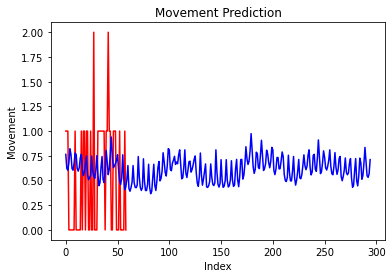

In [172]:
plt.plot(train_y, color='red', label='Real Movement')
plt.plot(predict_train, color='blue', label='Predicted')
plt.title('Movement Prediction')
plt.xlabel('Index')
plt.ylabel('Movement')